**Решаемая задача:** на основании истории объявлений cпрогнозировать стоимость квадрдатного метра квартиры

**Данные:** статистика цен, количество объявлений на Яндекс.недвижимости в различных районах Москвы. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install pandas-profiling==2.7.1

In [ ]:
!pip3 install --force-reinstall MarkupSafe==2.0.1

  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling as prof
from datetime import datetime as dt
import matplotlib.pyplot as plt
import json
from dateutil.relativedelta import relativedelta
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline
pd.set_option('max_columns', 500)


PATH = './drive/MyDrive/Colab Notebooks/Lina/'

In [ ]:
def ti():
    print(dt.now().replace(microsecond=0))
       
def get_zaic(df,*args):
    ti()
    if not(isinstance(df,pd.DataFrame) or isinstance(df,pd.Series)):
        print('Не могу вернуть размер для объекта с типом',type(df))
    elif isinstance(df,pd.Series) or isinstance(df,pd.DataFrame) and df.shape[1] == 1:
        print(round(df.memory_usage(deep=True)/1024**2,2),'Mb')
    else:
        print(round(df.memory_usage(deep=True).sum()/1024**2,2),'Mb')
    print(df.shape)

## Загрузим данные 

Описание полей в файле price_train.tsv:

* **city_quadkey** - полигон, его координаты можно его узнать из скрипта quadkey.py
* **month** - месяц, за который указаны данные в датасете
* **apartment_ratio** - доля квартир в этом районе в этом месяце со статусом "апартаменты" 
* **offers_in_sites_ratio** - доля офферов в ЖК в этом районе в этом месяце
* **unique_active_buildings_count** - количество домов, в которых есть квартиры в продаже в этом районе в этом месяце
* **AVG_PRICE_SQM** - средняя цена за квадратный метр	в этом районе в этом месяце
* **unique_active_building_series_count** - количество уникальных серий домов, в которых есть квартиры в продаже в этом районе в этом месяце	
* **rooms_offered_*_ratio** - доля квартир указанной в * комнатности от всех квартир в продаже в этом районе в этом месяце 	
* **median_price_sqm** - медианы цены за кв.м. в этом районе в этом месяце	
* **total_area_avg** - средний метраж продаваемой квартиры в этом районе в этом месяце	
* **studio_ratio** - доля объявлений о продаже студии среди всех объявлений в этом районе в этом месяце	
* **offer_count** - число объявлений о продаже квартир в этом районе в этом месяце	

In [ ]:
df_price = pd.read_table(PATH + 'price_train.tsv')
df_price.month = df_price.month.apply(pd.to_datetime)
# df_price['next_month'] = df_price['month'].apply(lambda x: x + 
#                                                  relativedelta(months=1))
df_price.drop(columns=['offers_in_sites_ratio'], inplace=True)  # constss
print(df_price.month.min(), df_price.month.max())
get_zaic(df_price)
df_price.head(3)

2017-01-01 00:00:00 2019-08-01 00:00:00
2022-05-21 12:13:31
17.73 Mb
(166027, 14)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0


In [ ]:
# get_zaic(df_price)
# df_price = pd.merge(
#     df_price.drop(columns=['next_month']), 
#     df_price[['avg_price_sqm', 'city_quadkey', 'next_month']].rename(columns={'avg_price_sqm': 'avg_price_sqm_next'}), 
#     left_on=['city_quadkey', 'month'], 
#     right_on=['city_quadkey', 'next_month'],
#     how='left')
# print()
# df_price.dropna(inplace=True)
# get_zaic(df_price)
# df_price.drop(columns=['next_month'], inplace=True)
# df_price.head(3)

Описание полей в датасете про базу домов price_housebase.tsv:

* **city_quadkey** - полигон, его координаты можно его узнать из скрипта quadkey.py
* **building_id** - id дома
* **unified_address** - адрес дома
* **building_series_id** - id серии дома
* **beauty_cnt** - количество салонов красоты в этом районе city_quadkey	
* **shopping_cnt** - количество магазинов в этом районе city_quadkey	 
* **cafe_restaurant_eating_out_cnt** - количество точек общественного питания в этом районе city_quadkey	
* **entertainment_cnt** - количество организаций в сфере развлечений в этом районе city_quadkey
* **sport_cnt** - количество спортивных организаций в этом районе city_quadkey
* **chain_cnt** - количество сетевых организаций в этом районе city_quadkey
* **groceries_and_everyday_items_cnt** - количество продуктовых магазинов в этом районе city_quadkey	
* **art_cnt** - количество организаций в сфере искусства (музеи, галереи и т.п.) в этом районе city_quadkey
* **healthcare_cnt** - количество организаций в сфере здравоохранения в этом районе city_quadkey	
* **flats_count** - количество квартир в доме	
* **laundry_and_repair_services_cnt** - количество прачечных и ремонтных мастерских в этом районе city_quadkey	
* **latitude, longitude** - координаты дома
* **expect_demolition** - дом входит в программу реновации и ожидает сноса
* **ceiling_height** - высота потолков в доме	
* **has_elevator** - наличие лифта в доме	
* **build_year** - год постройки дома

In [ ]:
df_house = pd.read_table(PATH + 'price_housebase.tsv')
get_zaic(df_house)
df_house.expect_demolition = df_house.expect_demolition.apply(int)
df_house.has_elevator = df_house.has_elevator.apply(int)
df_house.head(3)

2022-05-21 12:13:33
45.33 Mb
(112203, 23)


,beauty_cnt,building_id,building_series_id,shopping_cnt,flats_count,latitude,building_type,cafe_restaurant_eating_out_cnt,unified_address,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,site_id,healthcare_cnt,expect_demolition,longitude,ceiling_height,has_elevator,laundry_and_repair_services_cnt,build_year,city_quadkey
0,36.0,3031030817531317628,0,45.0,0,55.705219,BRICK,24.0,"Россия, Москва, 1-й Автозаводский проезд, 3",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.656994,0.0,1,38.0,1937,120310101302011
1,36.0,3031030817531317630,0,45.0,0,55.704845,BRICK,24.0,"Россия, Москва, 1-й Автозаводский проезд, 5",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.657295,0.0,0,38.0,1962,120310101302011
2,36.0,1764947998512909470,0,45.0,0,55.704697,UNKNOWN,24.0,"Россия, Москва, 1-й Автозаводский проезд, 7/1",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.658203,0.0,0,38.0,0,120310101302011


Обработаем с помощью метода sklearn.preprocessing.OneHotEncoder категорию дома. Достаточно посмотреть распределение. Видим хвост, который можно объединить в одну категорию other и с помощью OneHotEncoder распределить на весь датасет. 

In [ ]:
display(df_house.building_type.value_counts(normalize=True))
df_house.building_type = df_house.building_type.apply(lambda x: 'ANOTHER' if x in 
                                                      ['MONOLIT_BRICK', 
                                                       'WOOD', 
                                                       'METAL', 
                                                       'FERROCONCRETE'] else x)
df_house = pd.get_dummies(df_house, columns=['building_type'])
df_house.head(3)

BRICK            0.358359
PANEL            0.314751
UNKNOWN          0.200119
MONOLIT          0.081923
BLOCK            0.034206
MONOLIT_BRICK    0.008021
WOOD             0.002594
METAL            0.000018
FERROCONCRETE    0.000009
Name: building_type, dtype: float64

,beauty_cnt,building_id,building_series_id,shopping_cnt,flats_count,latitude,cafe_restaurant_eating_out_cnt,unified_address,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,site_id,healthcare_cnt,expect_demolition,longitude,ceiling_height,has_elevator,laundry_and_repair_services_cnt,build_year,city_quadkey,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN
0,36.0,3031030817531317628,0,45.0,0,55.705219,24.0,"Россия, Москва, 1-й Автозаводский проезд, 3",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.656994,0.0,1,38.0,1937,120310101302011,0,0,1,0,0,0
1,36.0,3031030817531317630,0,45.0,0,55.704845,24.0,"Россия, Москва, 1-й Автозаводский проезд, 5",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.657295,0.0,0,38.0,1962,120310101302011,0,0,1,0,0,0
2,36.0,1764947998512909470,0,45.0,0,55.704697,24.0,"Россия, Москва, 1-й Автозаводский проезд, 7/1",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.658203,0.0,0,38.0,0,120310101302011,0,0,0,0,0,1


Выделяем колонки, которые нам инетересны для работы, создаем объект группировки, к которому далее применяем агрегирующие функции min, max, avg:

In [ ]:
useful_cols = [
    'beauty_cnt',
    'shopping_cnt',
    'flats_count',
    'cafe_restaurant_eating_out_cnt',
    'entertainment_cnt',
    'sport_cnt',
    'chain_cnt',
    'groceries_and_everyday_items_cnt',
    'art_cnt',
    'healthcare_cnt',
    'expect_demolition',
    'ceiling_height',
    'laundry_and_repair_services_cnt',
    'building_type_ANOTHER',
    'building_type_BLOCK',
    'building_type_BRICK',
    'building_type_MONOLIT',
    'building_type_PANEL',
    'building_type_UNKNOWN'
]
grouped_housebase = df_house[useful_cols + 
                             ['city_quadkey']].groupby("city_quadkey")

## Добавим информацию о домах

In [ ]:
get_zaic(df_price)

df_price = df_price.merge(grouped_housebase.mean(), how="left", 
                          left_on="city_quadkey", 
                          suffixes=[None,"_bmean"], right_index=True)
df_price = df_price.merge(grouped_housebase.max(),  
                          how="left", left_on="city_quadkey", 
                          suffixes=[None,"_bmax"], right_index=True)
df_price = df_price.merge(grouped_housebase.min(),  
                          how="left", left_on="city_quadkey", 
                          suffixes=[None,"_bmin"], right_index=True)
print()
get_zaic(df_price)
df_price.head(3)

2022-05-21 12:13:33
17.73 Mb
(166027, 14)

2022-05-21 12:13:33
76.63 Mb
(166027, 71)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0


## Фичи из даты + праздники

В данных у нас только месяц, поэтому можем достать информацию по номеру месяца и квартала:

In [ ]:
df_price['month_num'] = df_price['month'].apply(lambda x: x.month)
df_price['quarter'] = df_price['month'].apply(lambda x: x.quarter)
df_price.head(3)

,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2


Добавляем данные по праздничным и предпраздничным дням из календарей consultant:

In [ ]:
def get_days_cnt(x, dates_list):
    cnt = 0
    for elem in dates_list:
        if x.month == elem.month and x.year == elem.year:
            cnt += 1
    return cnt


preholidays = list()
holidays = list()

for year in list(range(2017, 2019)):
    with open(PATH + './consultant' +str(year) + '.json') as f:
        calend = json.load(f)
        for elem in calend['preholidays']:
            preholidays.append(pd.to_datetime(elem))
        for elem in calend['holidays']:
            holidays.append(pd.to_datetime(elem))
        if 'nowork' in calend:
            for elem in calend['nowork']:
                holidays.append(pd.to_datetime(elem))

df_price['prehol_cnt'] = df_price['month'].apply(lambda x: get_days_cnt(x, preholidays))
df_price['hol_cnt'] = df_price['month'].apply(lambda x: get_days_cnt(x, holidays))
df_price.head(3)

,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10


## Лаги по таргету и сильной фиче
В силу специфики временных рядов можно попробовать добавить лаги. В финальном варианте эта часть закомментирована, потому что гипотеза не оправдалась.

In [ ]:
# df_price['prev_month'] = df_price['month'].apply(lambda x: x - 
#                                                  relativedelta(months=1))

In [ ]:
# get_zaic(df_price)
# df_price = pd.merge(
#     df_price.drop(columns=['prev_month']), 
#     df_price[['avg_price_sqm', 
#               'city_quadkey', 
#               'prev_month', 
#               'median_price_sqm']].rename(columns={'avg_price_sqm': 
#                                                    'avg_price_sqm_prev', 
#                                                    'median_price_sqm': 
#                                                    'median_price_sqm_prev'}), 
#     left_on=['city_quadkey', 'month'], 
#     right_on=['city_quadkey', 'prev_month'],
#     how='left')
# print()
# get_zaic(df_price)
# df_price.drop(columns=['prev_month'], inplace=True)
# df_price.head(3)

Добавляем факторы: медианная цена за кв.м. средняя цена за квадратный метр. Создаю колонку 'prev_month', смещение на месяц назад. Добавляем фичи в датасет. 
 

##Дата +

In [ ]:
def det_data(df_price):
    df_price['q'] = df_price['month'].dt.quarter
    df_price['m'] = df_price['month'].dt.month
    df_price.loc[(df_price['m'] >= 12) | (df_price['m'] <= 2), 's'] = 1 # 'Winter'
    df_price.loc[(df_price['m'] >= 3) & (df_price['m'] <= 5), 's'] = 2 # 'Spring'
    df_price.loc[(df_price['m'] >= 6) & (df_price['m'] <= 8), 's'] = 3 # 'Summer'
    df_price.loc[(df_price['m'] >= 9) & (df_price['m'] <= 11), 's'] = 4 # 'Autumn'
    df_price['s'] = df_price['s'].astype(int)
    
    return df_price

df_price = det_data(df_price)

df_price.head()

,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,q,m,s
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9,1,2,1
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11,1,3,2
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10,2,6,3
3,0.0,1,43478.261719,2018-07-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,7,3,0,9,3,7,3
4,0.0,1,36250.000000,2017-01-01,1,1.0,120132231322113,35714.285156,0.0,0.0,56.0,0.0,3,0.0,0.0,0.0,3.666667,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.588889,0.0,0.0,0.0,0.0,0.0,0.555556,0.444444,0.0,0.0,27,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0,2.7,0.0,0,0,0,0,1,1,0.0,0.0,0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0,0.0,0.0,0,0,0,0,0,0,1,1,0,14,1,1,1


## Посмотрим на данные
Можно графиками в питоне с использованием базовых библиотек или более продвинутых. А можно в BI системах (https://datalens.yandex.ru/ud7ndrq1r6zsm-linasf)

Также отдельно прилагается HTML файл с отчетом pandas-profiling: отчет по всем переменным, показывает пропуски, корреляцию

In [ ]:
get_zaic(df_price)
df_price.to_csv(PATH + 'df_price.csv')
df_price.head(3)

2022-05-21 12:13:54
85.5 Mb
(166027, 78)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,q,m,s
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9,1,2,1
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11,1,3,2
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10,2,6,3


Посмотрим на динамику средней цены за кв.м. по месяцам. Видим, что распределена достаточно ровное. Среднее выше медианы, что косвенно говорит, что есть влияющие выбросы. По количеству также нет аномалий. Данные довольно чистые. 

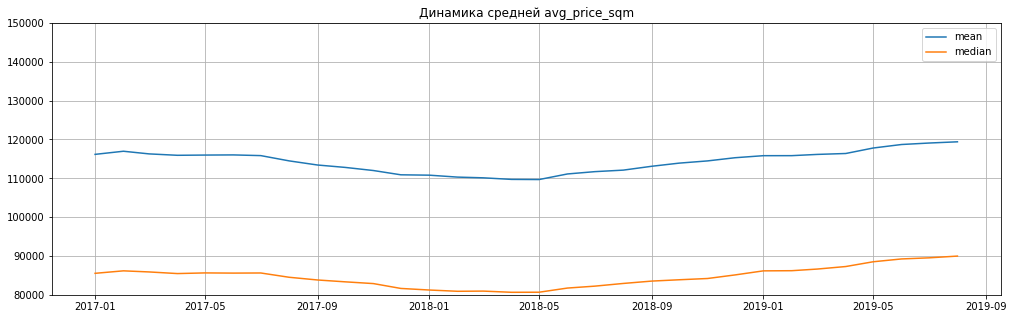

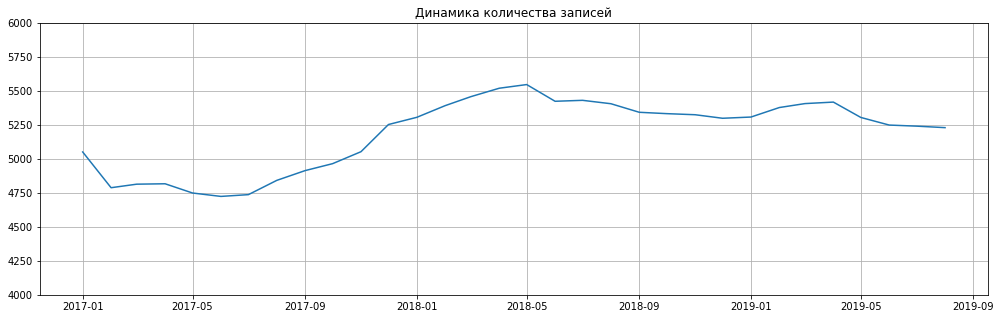

In [ ]:
df_gr = df_price.groupby('month').agg({'avg_price_sqm': 
                                       ['mean', 'count', 'median']}).reset_index()
df_gr.columns=df_gr.columns.droplevel()
df_gr.to_csv(PATH + 'df_gr_avg_price_sqm.csv')

fig = plt.figure(figsize=(17, 5))
plt.plot(df_gr[''], df_gr['mean'])
plt.plot(df_gr[''], df_gr['median'])
plt.title('Динамика средней avg_price_sqm')
plt.ylim([80000, 150000])
plt.grid(True)
plt.legend(['mean', 'median'])
plt.show()
print()
fig = plt.figure(figsize=(17, 5))
plt.plot(df_gr[''], df_gr['count'])
plt.title('Динамика количества записей')
plt.ylim([4000, 6000])
plt.grid(True)
plt.show()

Запоминаем границу по таргету. Убедимся, что если рисуем график распределния средней цены без ограничений, то видим слева хвост, что говорит о том, что есть выбросы, если ставим границу, то видим нормальное распределение. 

In [ ]:
ANOM_BORDER = df_price['avg_price_sqm'].quantile(0.95)

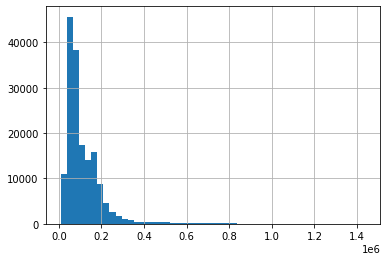

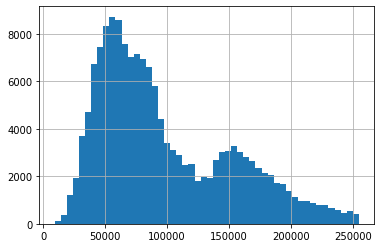

In [ ]:
df_price['avg_price_sqm'].hist(bins=50)
plt.show()
print()
df_price[df_price.avg_price_sqm <= ANOM_BORDER]['avg_price_sqm'].hist(bins=50)
plt.show()

Предпочтителен вариант не убирать аномалии, т.к. обучая модель на данных без аномалий, модель будет плохо работать с реальными данными без аномалий.  Достаточно понимать, что аномалии есть и влияют на распределение, но не отсекать их, так как алгоритмы градиентного бустинга и деревья хорошо с ними работают. 


##Посмотрим на данные в разрезе агрегированных переменных: +

count - The number of not-empty values.
mean - The average (mean) value.
std - The standard deviation.
min - the minimum value.
**50**% - The 50% percentile*.
max - the maximum value.

In [ ]:
display(df_price.describe(''))

,apartment_ratio,unique_active_buildings_count,avg_price_sqm,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,q,m,s
count,166027.000000,166027.000000,1.660270e+05,166027.000000,166027.000000,1.660270e+05,1.660270e+05,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,163674.000000,163674.000000,166027.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,166027.000000,166027.000000,163674.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,163674.000000,163674.000000,166027.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,166027.000000,166027.000000,163674.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,163674.000000,163674.000000,166027.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,163674.000000,166027.000000,166027.000000,163674.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000,166027.000000
mean,0.005473,8.284984,1.142708e+05,2.313913,0.247025,1.202815e+14,1.114977e+05,0.056155,0.318417,58.612785,0.017546,29.801340,0.375906,5.537880,14.041008,48.044307,4.396734,5.338924,3.409509,29.135153,10.372228,3.318212,5.786209,0.022778,1.126875,9.114838,0.012562,0.027451,0.327535,0.086351,0.318339,0.227760,5.537880,14.041008,193.678703,4.396734,5.338924,3.409509,29.135153,10.372228,3.318212,5.786209,0.090371,3.042864,9.114838,0.121378,0.208231,0.739012,0.406205,0.724436,0.839448,5.537880,14.041008,2.783565,4.396734,5.338924,3.409509,29.135153,10.372228,3.318212,5.786209,0.000404,0.082046,9.114838,0.000879,0.001096,0.042535,0.006674,0.040861,0.026706,5.992923,2.341499,0.284863,7.316834,2.341499,5.992923,2.399784
std,0.046727,8.513067,1.001687e+05,2.045387,0.244993,6.531200e+10,9.246779e+04,0.141913,0.275527,29.273578,0.082098,55.324011,0.278070,10.466641,48.024177,59.358358,10.229043,6.834804,4.502075,47.109938,13.940460,8.000740,11.381596,0.091192,0.766342,17.112005,0.056044,0.081898,0.301298,0.172727,0.312288,0.221468,10.466641,48.024177,241.209282,10.229043,6.834804,4.502075,47.109938,13.940460,8.000740,11.381596,0.286713,2.678823,17.112005,0.326567,0.406044,0.439175,0.491125,0.446799,0.367119,10.466641,48.024177,23.821303,10.229043,6.834804,4.502075,47.109938,13.940460,8.000740,11.381596,0.020085,0.537860,17.112005,0.029641,0.033091,0.201807,

# Посмотрим информацию о признаках и пропусках

In [ ]:
df_price.head().T

,0,1,2,3,4
apartment_ratio,0.0,0.0,0.0,0.0,0.0
unique_active_buildings_count,1,1,1,1,1
avg_price_sqm,22727.273438,22727.273438,43478.261719,43478.261719,36250.0
month,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2017-01-01 00:00:00
unique_active_building_series_count,1,1,1,1,1
...,...,...,...,...,...
prehol_cnt,1,1,1,0,0
hol_cnt,9,11,10,9,14
q,1,1,2,3,1
m,2,3,6,7,1


In [ ]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166027 entries, 0 to 166026
Data columns (total 78 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   apartment_ratio                        166027 non-null  float64       
 1   unique_active_buildings_count          166027 non-null  int64         
 2   avg_price_sqm                          166027 non-null  float64       
 3   month                                  166027 non-null  datetime64[ns]
 4   unique_active_building_series_count    166027 non-null  int64         
 5   rooms_offered_3_ratio                  166027 non-null  float64       
 6   city_quadkey                           166027 non-null  int64         
 7   median_price_sqm                       166027 non-null  float64       
 8   rooms_offered_4_more_ratio             166027 non-null  float64       
 9   rooms_offered_1_ratio                  166027 no

Работа с пропусками, данные довольно полные:

In [ ]:
df_price.isnull().sum()

apartment_ratio                        0
unique_active_buildings_count          0
avg_price_sqm                          0
month                                  0
unique_active_building_series_count    0
                                      ..
prehol_cnt                             0
hol_cnt                                0
q                                      0
m                                      0
s                                      0
Length: 78, dtype: int64

In [ ]:
df_price.isnull().sum()

apartment_ratio                        0
unique_active_buildings_count          0
avg_price_sqm                          0
month                                  0
unique_active_building_series_count    0
                                      ..
prehol_cnt                             0
hol_cnt                                0
q                                      0
m                                      0
s                                      0
Length: 78, dtype: int64

Для разбиения признаков по категориям посмотрим на уникальные значения признаков и их количество

In [ ]:
df_price.agg({'nunique', lambda x: x.unique()}).transpose()


,<lambda>,nunique
apartment_ratio,"[0.0, 0.0384615384615384, 0.0476190476190476, ...",1944
unique_active_buildings_count,"[1, 4, 6, 5, 3, 2, 8, 9, 10, 7, 13, 11, 12, 16...",77
avg_price_sqm,"[22727.2734375, 43478.26171875, 36250.0, 33616...",120419
month,"[2018-02-01T00:00:00.000000000, 2018-03-01T00:...",32
unique_active_building_series_count,"[1, 2, 3, 9, 5, 4, 8, 7, 6, 10, 11, 12, 13, 14...",15
...,...,...
prehol_cnt,"[1, 0]",2
hol_cnt,"[9, 11, 10, 14, 8, 0]",6
q,"[1, 2, 3, 4]",4
m,"[2, 3, 6, 7, 1, 4, 5, 8, 9, 10, 11, 12]",12


##Посмотрим распределение числовых признаков:

## histplot

In [ ]:
import seaborn as sns

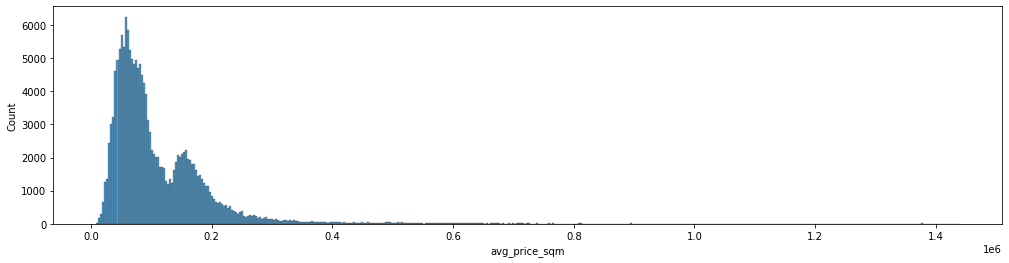

In [ ]:
plt.figure(figsize=(17,4))
sns.histplot(data=df_price, x='avg_price_sqm');

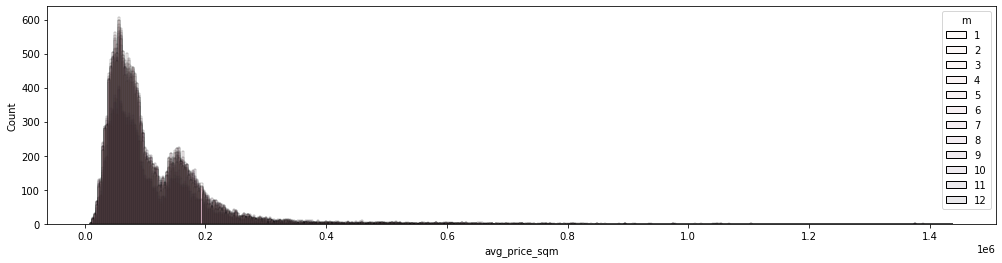

In [ ]:
plt.figure(figsize=(17,4))
sns.histplot(data=df_price, x='avg_price_sqm', hue='m', alpha=0.1);

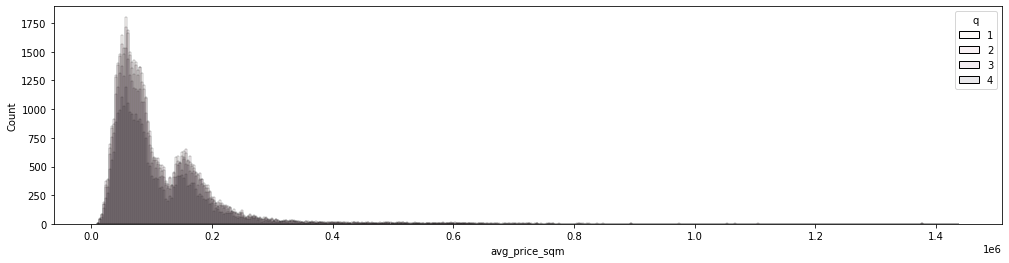

In [ ]:
plt.figure(figsize=(17,4))
sns.histplot(data=df_price, x='avg_price_sqm', hue='q', alpha=0.1);

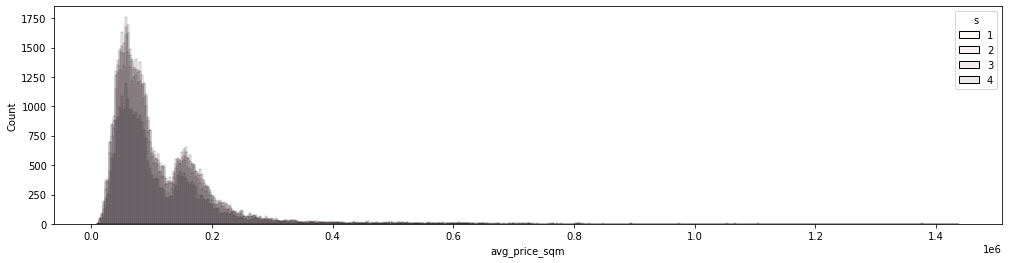

In [ ]:
plt.figure(figsize=(17,4))
sns.histplot(data=df_price, x='avg_price_sqm', hue='s', alpha=0.1);

##boxplot**

Построим графики boxplot, которые помогут увидеть, как меняется распределение средней стоимости кв.м. в зависимости от года и месяца

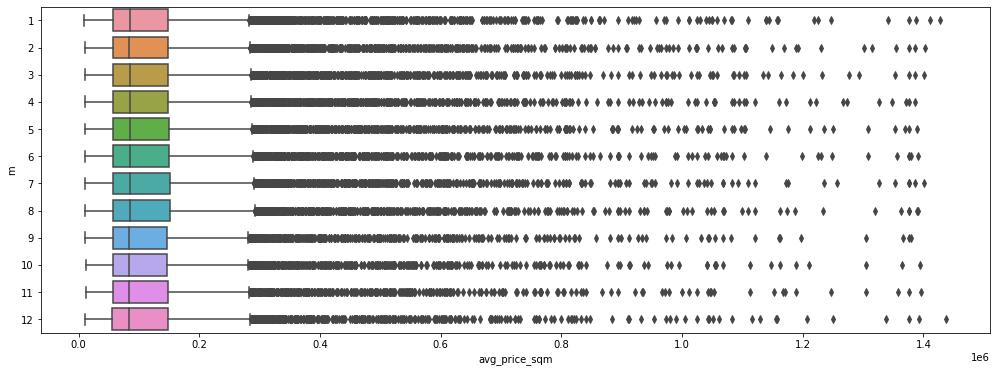

In [ ]:
plt.figure(figsize=(17,6))
sns.boxplot(data=df_price, x='avg_price_sqm', y='m', orient='h');

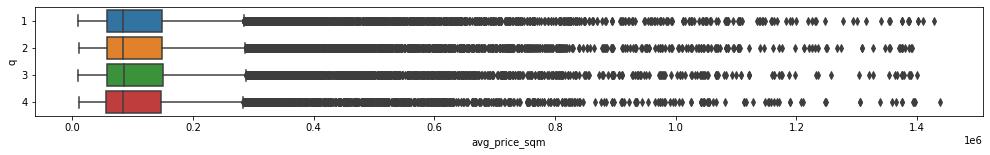

In [ ]:
plt.figure(figsize=(17,2))
sns.boxplot(data=df_price, x='avg_price_sqm', y='q', orient='h');

##lineplot

Распределение во времени средней и медианной стоимости кв.м.

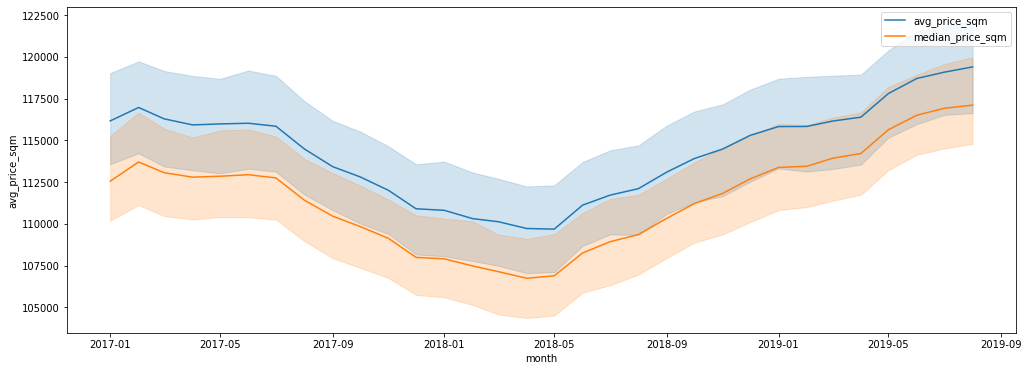

In [ ]:
plt.figure(figsize=(17,6))
sns.lineplot(data=df_price, y='avg_price_sqm', x='month', label='avg_price_sqm');
sns.lineplot(data=df_price, y='median_price_sqm', x='month', label='median_price_sqm');

Распределение во времени объявлений о продаже квартир 

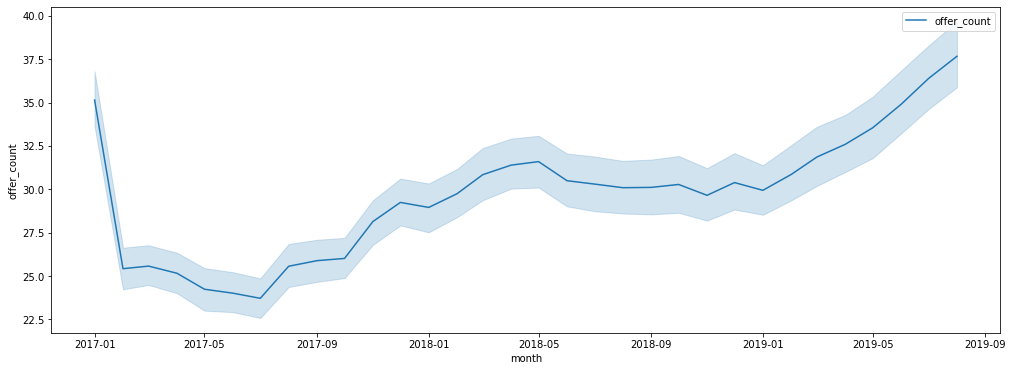

In [ ]:
plt.figure(figsize=(17,6))
sns.lineplot(data=df_price, y='offer_count', x='month', label='offer_count');

Распределение во времени среднего метража продаваемой квартиры 

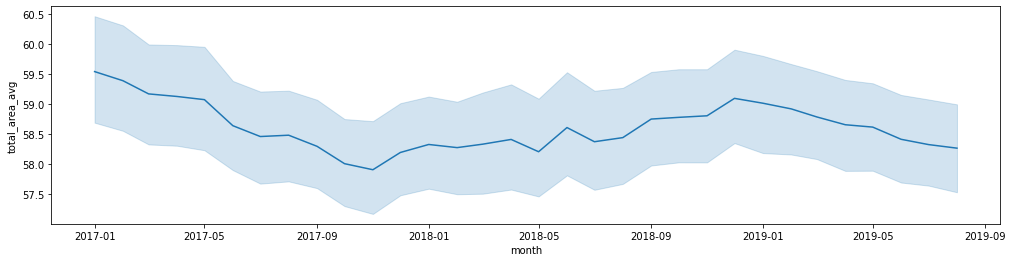

In [ ]:
plt.figure(figsize=(17,4))
sns.lineplot(data=df_price, y='total_area_avg', x='month');

Распределение во времени количества домов и количества уникальных серий домов, в которых есть квартиры в продаже 

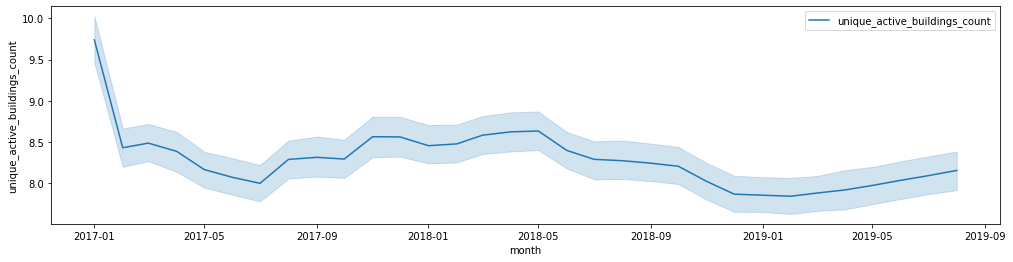

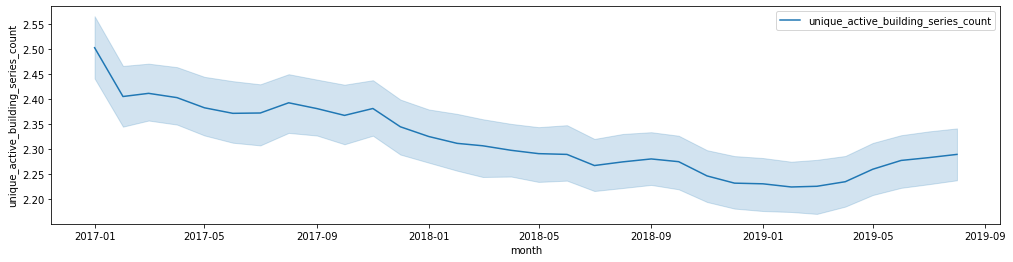

In [ ]:
plt.figure(figsize=(17,4))
sns.lineplot(data=df_price, y='unique_active_buildings_count', x='month', label='unique_active_buildings_count');
plt.figure(figsize=(17,4))
sns.lineplot(data=df_price, y='unique_active_building_series_count', x='month', label='unique_active_building_series_count');

Распределение во времени предложений по квартирам с разным количеством комнат 

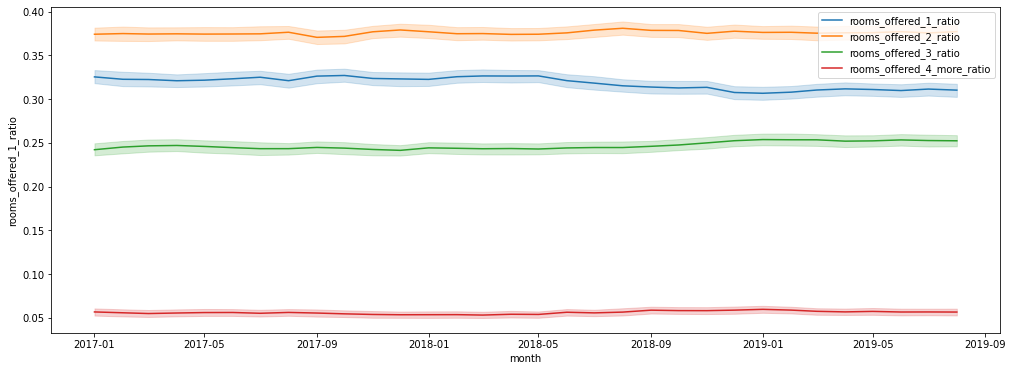

In [ ]:
plt.figure(figsize=(17,6))
sns.lineplot(data=df_price, y='rooms_offered_1_ratio', x='month', label='rooms_offered_1_ratio');
sns.lineplot(data=df_price, y='rooms_offered_2_ratio', x='month', label='rooms_offered_2_ratio');
sns.lineplot(data=df_price, y='rooms_offered_3_ratio', x='month', label='rooms_offered_3_ratio');
sns.lineplot(data=df_price, y='rooms_offered_4_more_ratio', x='month', label='rooms_offered_4_more_ratio');

Распределение во времени предложений по типу квартир: студия и апартаменты

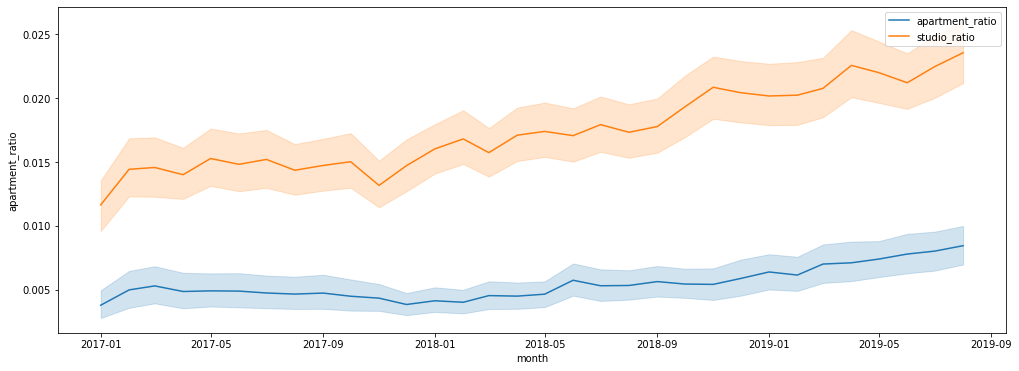

In [ ]:
plt.figure(figsize=(17,6))
sns.lineplot(data=df_price, y='apartment_ratio', x='month', label='apartment_ratio');
sns.lineplot(data=df_price, y='studio_ratio', x='month', label='studio_ratio');

In [ ]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
init_notebook_mode(connected = True)
cf.go_offline()

##Разделим признаки на категории

In [ ]:
room_cols = ['rooms_offered_4_more_ratio','rooms_offered_3_ratio','rooms_offered_2_ratio','rooms_offered_1_ratio','avg_price_sqm']
cat_cols = ['building_type_ANOTHER_bmax', 'unique_active_building_series_count', 'expect_demolition_bmin','quarter', 'prehol_cnt','month_num','hol_cnt']
num_cols = ['sport_cnt',
  'entertainment_cnt',
  'art_cnt',
  'unique_active_buildings_count',
  'beauty_cnt','healthcare_cnt',
  'cafe_restaurant_eating_out_cnt',
  'laundry_and_repair_services_cnt',
  'groceries_and_everyday_items_cnt',
  'shopping_cnt','chain_cnt',
  'expect_demolition',
  'offer_count','apartment_ratio',
  'studio_ratio',
  'flats_count',
  'ceiling_height',
  'median_price_sqm',
  'total_area_avg',
  'avg_price_sqm']

##Числовые признаки:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



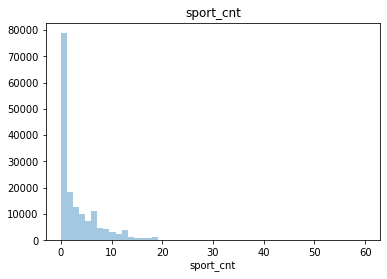

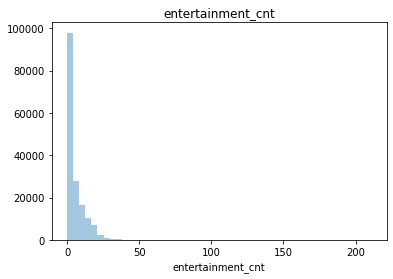

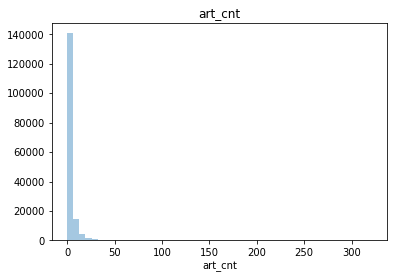

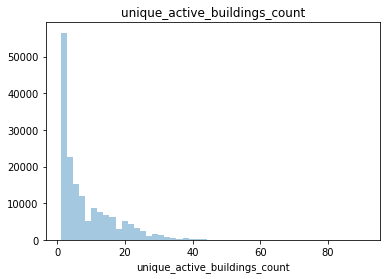

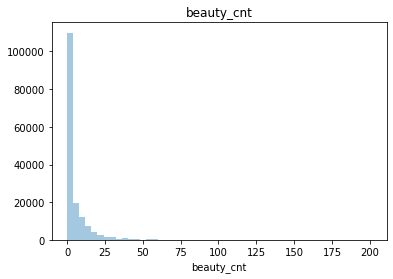

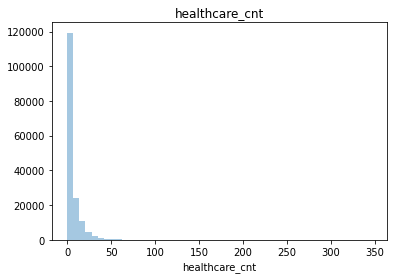

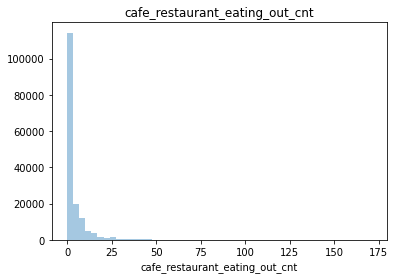

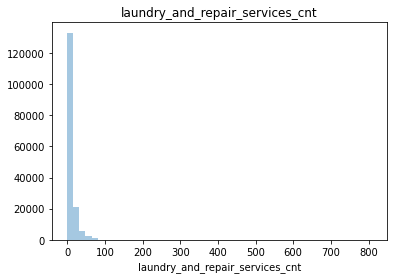

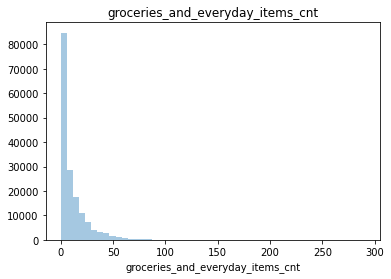

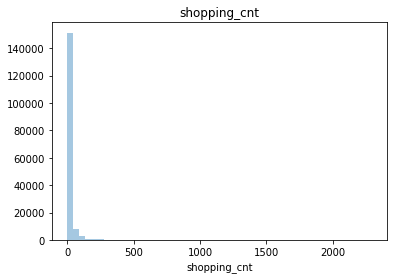

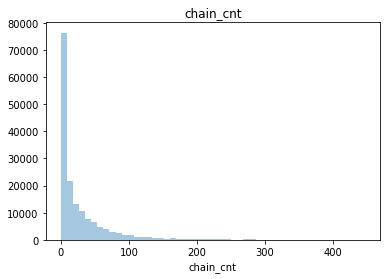

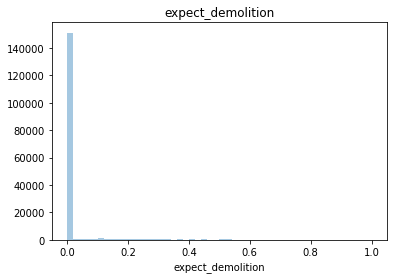

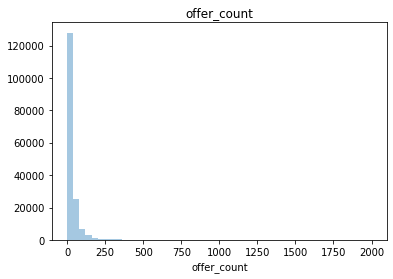

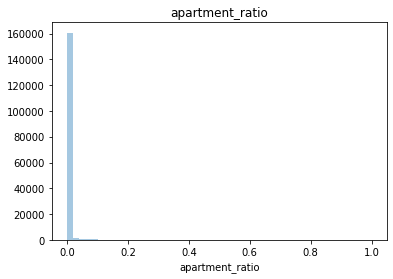

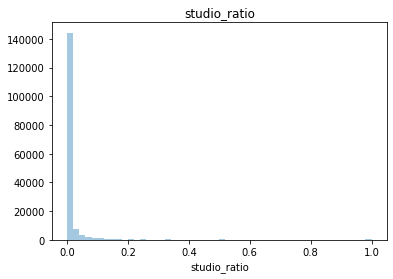

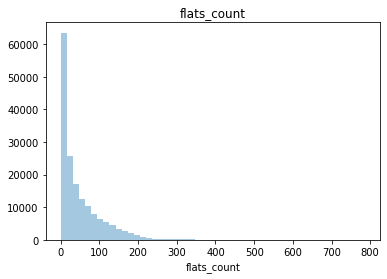

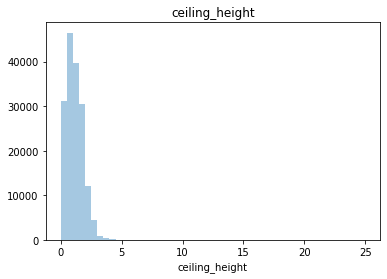

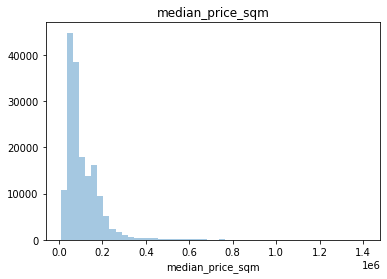

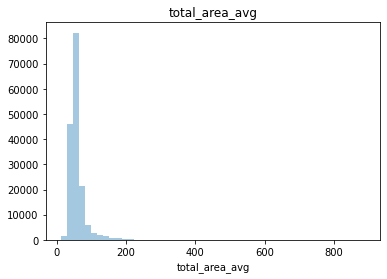

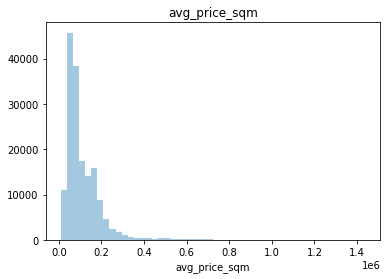

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for column in num_cols:
    plt.figure()
    sns.distplot(df_price[column], kde = False, rug=False)
    plt.title(column)
    plt.show()

##Категориальные признаки

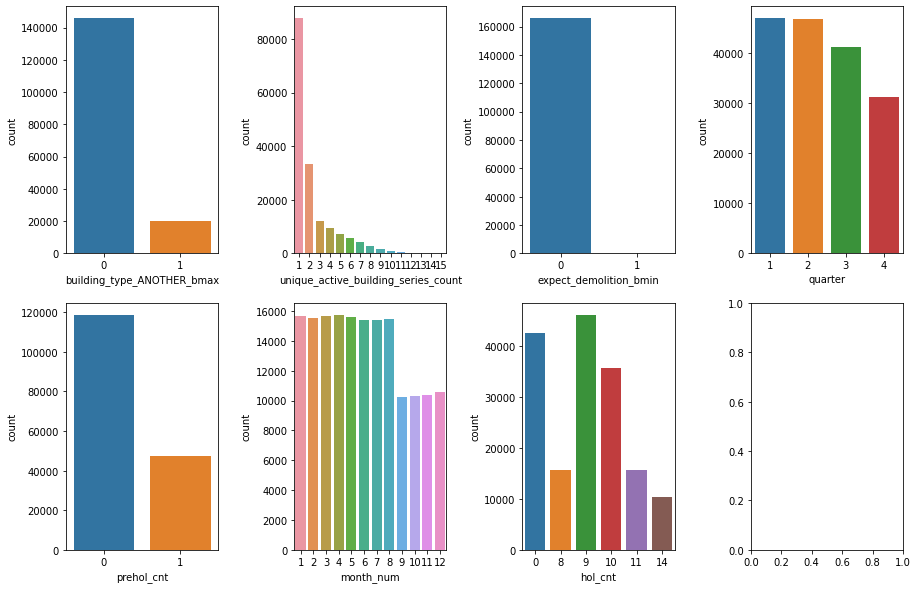

In [ ]:
fig,axes = plt.subplots(2, 4, figsize=(15,10))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
for i in range(len(cat_cols)):
    sns.countplot(x=cat_cols[i], data=df_price, ax=axes[i])

#Посмотрим на корреляцию численных переменных с целевой  

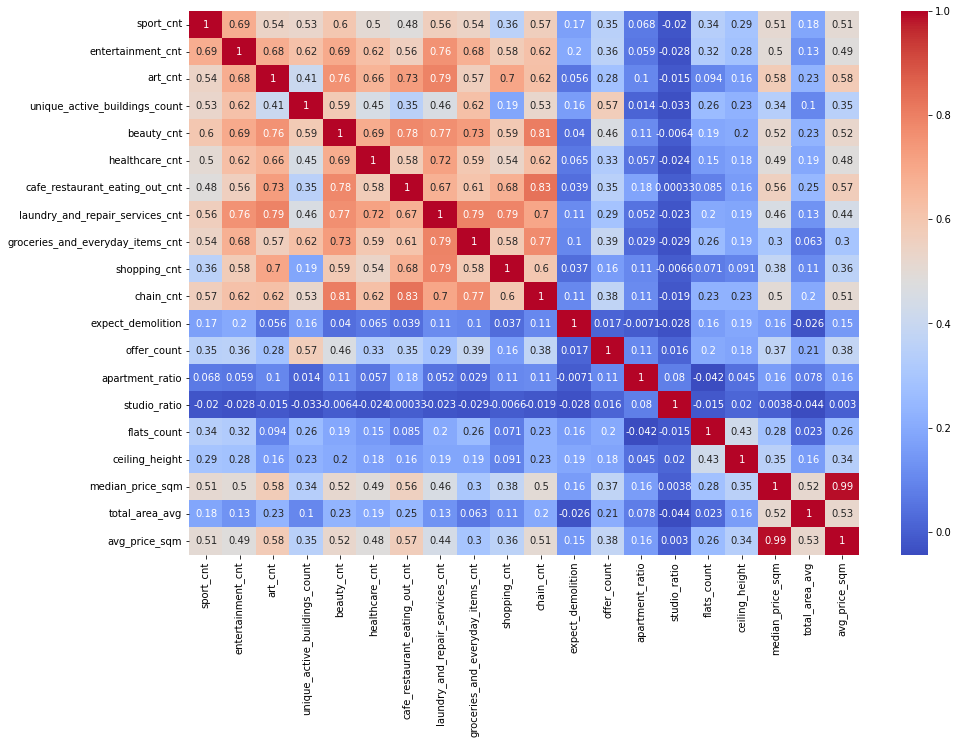

In [ ]:
corr_cols = num_cols 
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap((df_price[corr_cols]).corr(),cmap='coolwarm', annot=True)

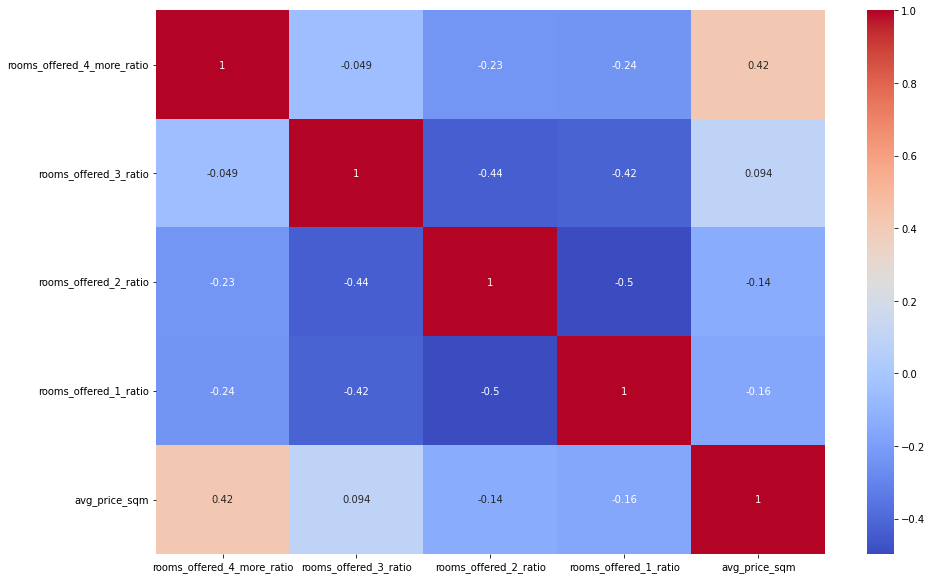

In [ ]:
corr_cols = room_cols 
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap((df_price[corr_cols]).corr(),cmap='coolwarm', annot=True)

____________________

## Проверим, что нет явного мусора

In [ ]:
isna_ser = df_price.isna().sum() / len(df_price)
assert len(isna_ser[isna_ser>0.9]) == 0

In [ ]:
%%time
cols_low_variance = df_price.fillna(-1234).std(axis=0) == 0
cols_low_variance = [elem for elem in cols_low_variance.index if cols_low_variance[elem]]
df_price = df_price.drop(cols_low_variance, axis=1)
print(cols_low_variance)

[]
CPU times: user 1.12 s, sys: 9.7 ms, total: 1.13 s
Wall time: 1.13 s
